# Real-world scenario in computational finance: portfolio optimization

The project concentrates on a four-asset portfolio optimization. The assets are two highly correlated and two weakly correlated stocks. The stock prices data from within a ten years long time period is downloaded from Yahoo Finance (YF).

The project consists of the following parts.  
1. Stock data load with initial formatting, analysis and visualization.
2. Construction of the portfolio with initial analysis of its components.
3. Construction of an efficient frontier for the considered portfolio and its mean-variance optimization.
4. Calculation of value at risk and expected shortfall for the optimal portfolio.
5. Stress testing of the optimized portfolio using Monte-Carlo simulations.
6. Mean-variance and maximizing Sharpe ratio portfolio optimizations with a GARCH(1,1)-based 30-day forward-looking volatility forecast.

---------------------------------

The project analyzes the Apple, Boeing, Google and Tesla financial data sets from within the period 01/01/2015 to 31/12/2024.

---------------------------------

Parameter/variable values that can be adjusted/selected according to one's computational needs are marked by a set of hashes at the end of a corresponding explanation line.

In [3]:
# installing the library that provides access to financial data on Yahoo Finance
!pip install yfinance

In [4]:
# installing the library that provides access to financial econometrics tools, arch project doi:10.5281/zenodo.593254
!pip install arch

In [5]:
import yfinance as yf

import requests
from bs4 import BeautifulSoup

import pandas as pd
pd.options.mode.chained_assignment = None   # disable warning on chain assignments

import numpy as np
from scipy.optimize import minimize

import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True
import matplotlib.dates as mdates

from IPython.display import display_html
import datetime as dt
from tabulate import tabulate
from arch import arch_model

from IPython.core.magic import register_cell_magic
from IPython import get_ipython
#
@register_cell_magic
def skip(line, cell):   # skip cell execution
    return

import warnings
warnings.filterwarnings('ignore')   # suppress warnings

#### Stock data load

In [7]:
# collecting historical close price data for a set of assets
tickers = ['AAPL', 'BA', 'GOOG', 'TSLA']
no_assets = len(tickers)

asset_colors = ['r', 'g', 'b', 'C1']   # colors related to assets for plotting purposes

start_date = '2015-01-01'
end_date = '2024-12-31'

data = yf.download(tickers, start = start_date, end = end_date, interval = '1d')['Close']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed


In [8]:
data.head()

Ticker,AAPL,BA,GOOG,TSLA
Date,,,,
2015-01-02,24.320433,113.657211,26.074965,14.620667
2015-01-05,23.635279,112.870056,25.531414,14.006000
2015-01-06,23.637510,111.540627,24.939672,14.085333
2015-01-07,23.968962,113.272377,24.896942,14.063333
2015-01-08,24.889908,115.275276,24.975445,14.041333


In [9]:
data.index = data.index.strftime('%d/%m/%Y')

In [10]:
data.reset_index(inplace = True)

In [11]:
data.head()

Ticker,Date,AAPL,BA,GOOG,TSLA
0,02/01/2015,24.320433,113.657211,26.074965,14.620667
1,05/01/2015,23.635279,112.870056,25.531414,14.006000
2,06/01/2015,23.637510,111.540627,24.939672,14.085333
3,07/01/2015,23.968962,113.272377,24.896942,14.063333
4,08/01/2015,24.889908,115.275276,24.975445,14.041333


In [12]:
data.shape

(2515, 5)

In [13]:
# number of trading days per year  #####################################
trading_days = 252

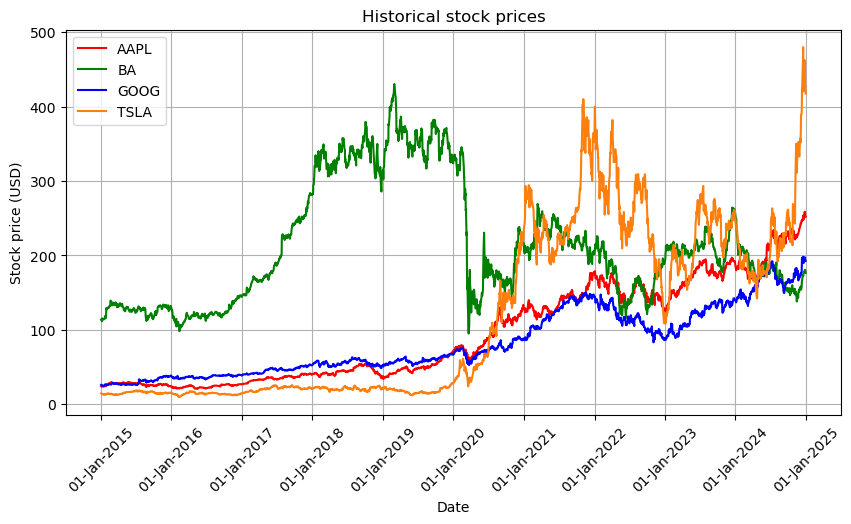

In [14]:
# plotting the historical stock prices
plt.figure(figsize = (10,5))
plt.title("Historical stock prices")
plt.xlabel("Date")
plt.ylabel("Stock price (USD)")

x = [dt.datetime.strptime(d, '%d/%m/%Y').date() for d in data['Date']]
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

i=0
for t in tickers:
    plt.plot(x, data[t], color = asset_colors[i], label = t)
    i += 1

plt.legend()
plt.xticks(rotation = 45)
plt.grid(True)

### Portfolio construction and initial analysis

In [16]:
# creating dataframes of stock prices on closing and corresponding dates
data_dict = {'AAPL': data['AAPL'], 'BA': data['BA'], 'GOOG': data['GOOG'], 'TSLA': data['TSLA']}
dates_dict = {'Date': data['Date']}

portfolio = pd.DataFrame(data_dict)
portfolio_dates = pd.DataFrame(dates_dict)

In [17]:
portfolio_dates_styler = portfolio_dates.head().style.set_table_attributes("style='display:inline'").set_caption('portfolio_dates')
portfolio_styler = portfolio.head().style.set_table_attributes("style='display:inline'").set_caption('portfolio')
display_html(portfolio_dates_styler._repr_html_() + portfolio_styler._repr_html_(), raw = True)

portfolio_dates 
 
 
   
 Date 
 
 
 
 
 0 
 02/01/2015 
 
 
 1 
 05/01/2015 
 
 
 2 
 06/01/2015 
 
 
 3 
 07/01/2015 
 
 
 4 
 08/01/2015 
 
 
 

 
 portfolio 
 
 
   
 AAPL 
 BA 
 GOOG 
 TSLA 
 
 
 
 
 0 
 24.320433 
 113.657211 
 26.074965 
 14.620667 
 
 
 1 
 23.635279 
 112.870056 
 25.531414 
 14.006000 
 
 
 2 
 23.637510 
 111.540627 
 24.939672 
 14.085333 
 
 
 3 
 23.968962 
 113.272377 
 24.896942 
 14.063333 
 
 
 4 
 24.889908 
 115.275276 
 24.975445 
 14.041333

In [18]:
# calculating daily asset returns
returns = np.log(portfolio[['AAPL', 'BA', 'GOOG', 'TSLA']] / portfolio[['AAPL', 'BA', 'GOOG', 'TSLA']].shift(1)).dropna()   #logarithmic
#returns = portfolio[['AAPL', 'BA', 'GOOG', 'TSLA']].pct_change().dropna()   # percentage

# mean returns of the assets
mean_returns = returns.mean()

# creating dataframe of dates corresponding to the returns
returns_dates = portfolio_dates.tail(-1)   # drop first row

In [19]:
# transforming the returns from daily to yearly
yearly_returns = returns * trading_days

# mean returns of the assets over the one-year time period
yearly_mean_returns = yearly_returns.mean()
yearly_mean_returns

AAPL    0.234339
BA      0.044147
GOOG    0.200488
TSLA    0.335963
dtype: float64

In [20]:
yearly_mean_returns = yearly_mean_returns.values

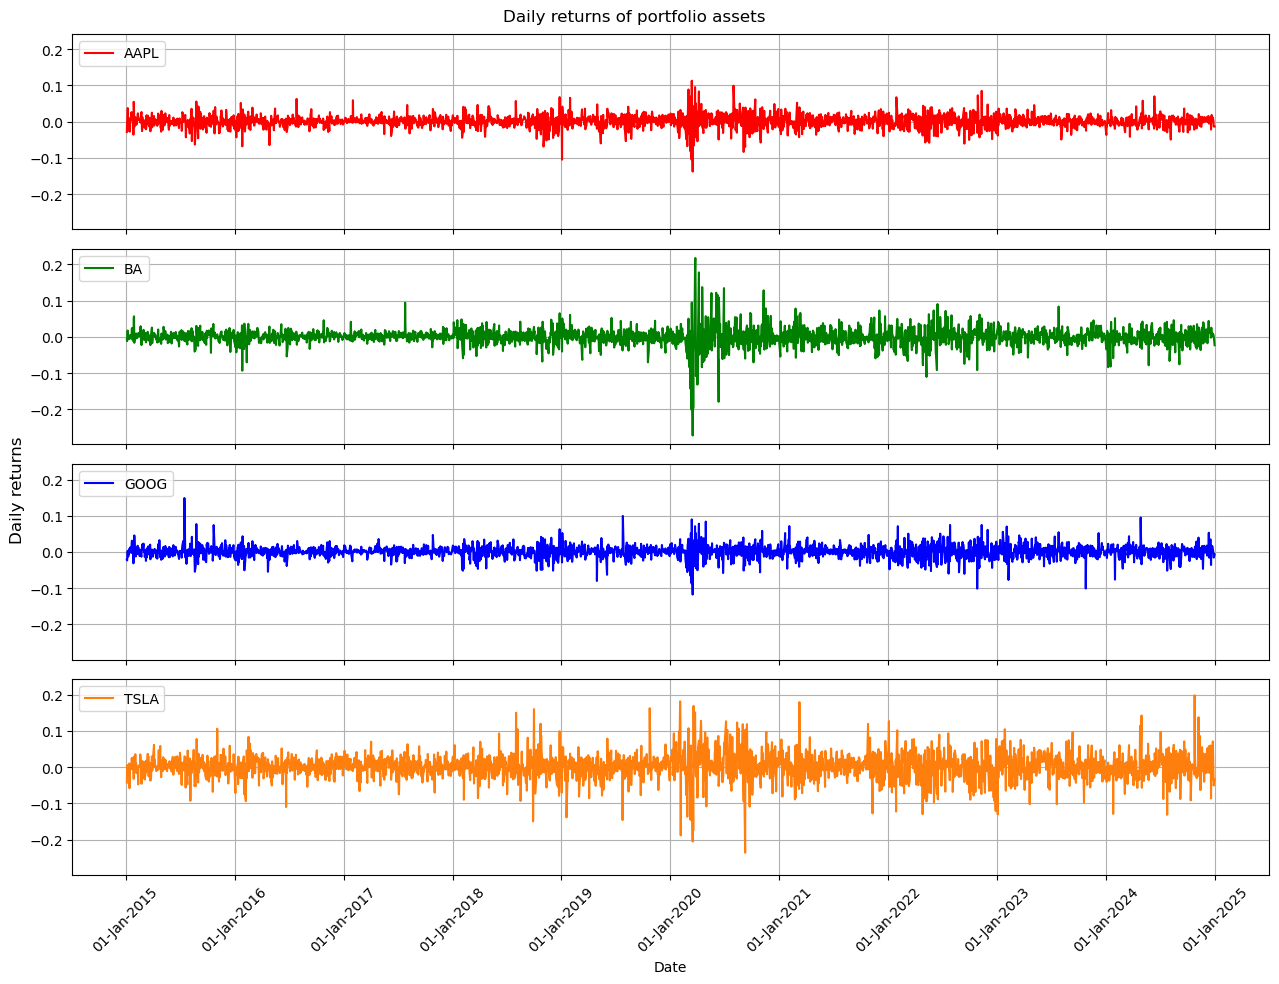

In [21]:
# plotting daily returns of the assets
fig, axs = plt.subplots(4, figsize = (13,10), sharex = True, sharey = True)
fig.suptitle("Daily returns of portfolio assets")
plt.xlabel("Date")
fig.supylabel("Daily returns")

x = [dt.datetime.strptime(d, '%d/%m/%Y').date() for d in returns_dates['Date']]
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

i=0
for t in tickers:
    axs[i].plot(x, returns[t], color = asset_colors[i], label = t)
    axs[i].legend(loc = 2)
    i += 1

plt.legend()
plt.xticks(rotation = 45)
plt.grid(True)
fig.tight_layout()

In [22]:
# calculating the covariance matrix of daily asset returns
cov_matrix = returns.cov()

In [23]:
# transforming the covariance matrix from daily to yearly
yearly_cov_matrix = cov_matrix * trading_days
yearly_cov_matrix

,AAPL,BA,GOOG,TSLA
AAPL,0.081053,0.046579,0.049012,0.068903
BA,0.046579,0.163214,0.043085,0.069798
GOOG,0.049012,0.043085,0.080929,0.059790
TSLA,0.068903,0.069798,0.059790,0.324971


In [24]:
# calculating the correlation matrix
corr_matrix = returns.corr()
corr_matrix

,AAPL,BA,GOOG,TSLA
AAPL,1.000000,0.404976,0.605147,0.424548
BA,0.404976,1.000000,0.374881,0.303070
GOOG,0.605147,0.374881,1.000000,0.368685
TSLA,0.424548,0.303070,0.368685,1.000000


### Efficient frontier

An efficient frontier is a set of portfolios that offer the highest expected return for the assumed risk level or the lowest risk for a given expected return. A successful optimization of the return versus risk paradigm should place a portfolio along the efficient frontier line.

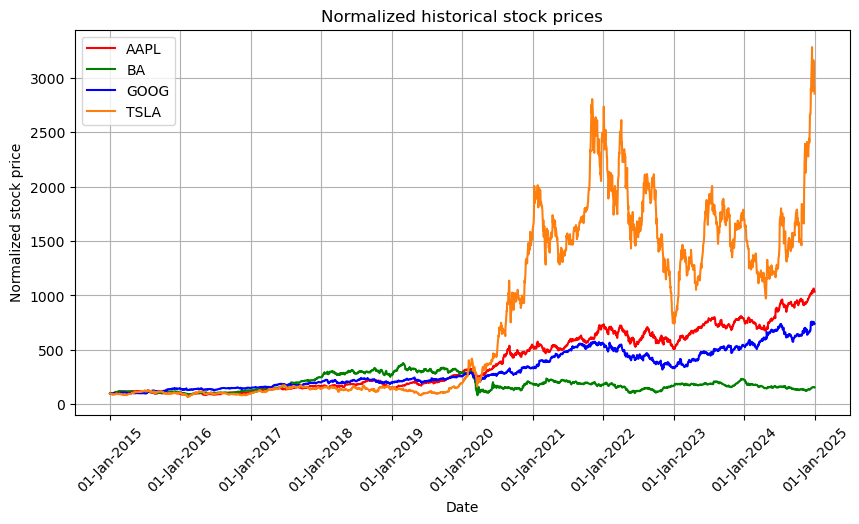

In [27]:
# plotting the normalized historical stock prices
normalized_prices = portfolio / portfolio.iloc[0,:] * 100

plt.figure(figsize = (10,5))
plt.title("Normalized historical stock prices")
plt.xlabel("Date")
plt.ylabel("Normalized stock price")

x = [dt.datetime.strptime(d, '%d/%m/%Y').date() for d in portfolio_dates['Date']]
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

i=0
for t in tickers:
    plt.plot(x, normalized_prices[t], color = asset_colors[i], label = t)
    i += 1

plt.legend()
plt.xticks(rotation = 45)
plt.grid(True)

In [28]:
# generating a set of random portfolios and calculating their returns and volatilities
returns_list = []
volatility_list = []

for r in range(5000):
    rand_weights = np.random.random(no_assets)   # generating random weights
    normalized_rand_weights = rand_weights / np.sum(rand_weights)   # random weights normalized to 1
    rand_portfolio_return = yearly_mean_returns.dot(normalized_rand_weights)   # expected return of a random portfolio
    returns_list.append(rand_portfolio_return)
    #
    rand_portfolio_variance = np.dot(np.dot(normalized_rand_weights.T, yearly_cov_matrix), normalized_rand_weights)   # variance of a random portfolio
    rand_portfolio_std = np.sqrt(rand_portfolio_variance)   # std of a random portfolio
    volatility_list.append(rand_portfolio_std)

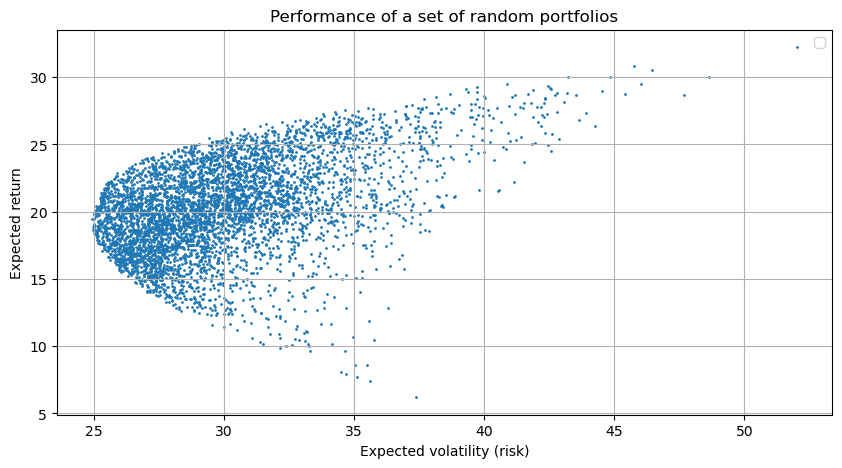

In [29]:
random_portfolios = pd.DataFrame({'Return': returns_list, 'Volatility': volatility_list}) * 100   # percentage values

random_portfolios.plot(x = 'Volatility', y = 'Return', kind = 'scatter', s = 1, figsize = (10,5))
plt.title("Performance of a set of random portfolios")
plt.xlabel("Expected volatility (risk)")
plt.ylabel("Expected return")
plt.legend()
plt.grid(True)

### Mean-variance portfolio optimization

Portfolio optimization is a process of selecting a set of assets and determining their distribution in the portfolio to achieve the best possible financial outcome. It means maximizing expected return and minimizing risk, while accounting for the investor's specific objectives.

The mean-variance portfolio optimization minimizes the portfolio volatility (risk) while obtaining the highest expected return given the constraints and bounds for the asset weights. The output of the procedure will be a set of optimal weights that generate the portfolio with minimum variance and a target level of return.

In [32]:
# calculating portfolio return
def mean_portfolio(weights, *args):
    
    mean_returns = args[0]
    portfolio_return = mean_returns.dot(weights)
    
    return portfolio_return

# calculating portfolio volatility
def std_portfolio(weights, *args):

    cov_matrix = args[1]
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    return portfolio_volatility

In [33]:
# bounds for portfolio weights: between 0 and 1
bounds = tuple((0,1) for i in range(no_assets))

# initial guess for portfolio weights: equal distribution  #####################################
initial_weights = np.array(no_assets * [1. / no_assets])

# constraints for portfolio optimization: weights sum to 1, no short-selling  #####################################
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
               {'type': 'eq', 'fun': lambda weights: mean_portfolio(weights, *args) - portfolio_target_return})

In [34]:
# target return of the portfolio  #####################################
portfolio_target_return = 0.2

In [35]:
# portfolio optimization
args = yearly_mean_returns, yearly_cov_matrix

opt_result = minimize(std_portfolio, initial_weights, args = args, method = 'SLSQP', bounds = bounds, constraints = constraints)
opt_weights = opt_result.x

Optimal portfolio weights:
+-------+--------+--------+--------+
| AAPL  | BA     | GOOG   | TSLA   |
+-------+--------+--------+--------+
| 0.448 | 0.1057 | 0.4399 | 0.0064 |
+-------+--------+--------+--------+
Optimal portfolio expected return: 20.00%
Optimal portfolio volatility: 24.97%


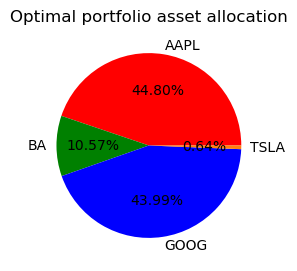

In [36]:
# calculating optimal portfolio performance
opt_return = mean_portfolio(opt_weights, *args)
opt_volatility = std_portfolio(opt_weights, *args)

print(f"Optimal portfolio weights:")
d = [tickers, np.round(opt_weights, 4)]
print(tabulate(d, tablefmt = 'grid'))
#
print(f"Optimal portfolio expected return: {opt_return*100:.2f}%")
print(f"Optimal portfolio volatility: {opt_volatility*100:.2f}%")
#
plt.figure(figsize = (5,3))
plt.pie(opt_weights, labels = tickers, autopct = '%1.2f%%', colors = asset_colors)
plt.title("Optimal portfolio asset allocation")
plt.show()

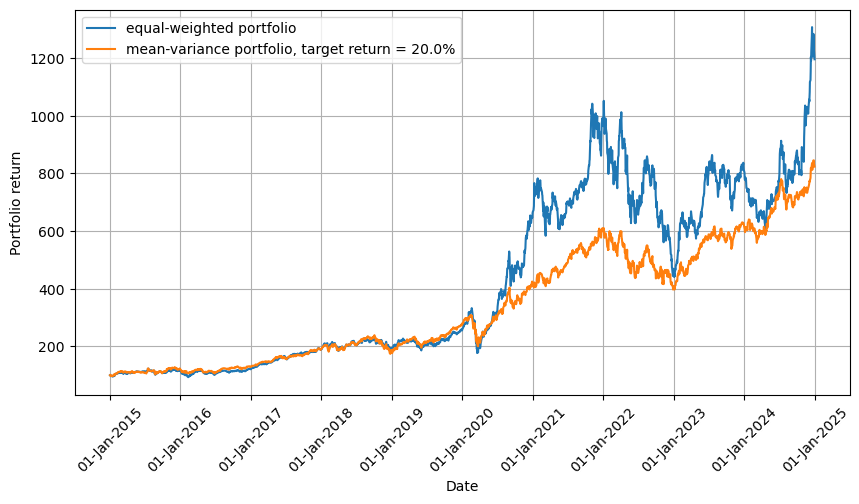

In [37]:
# comparison between the equal-weighted and optimal portfolios
equal_weighted_portfolio = normalized_prices.dot(initial_weights)
optimal_portfolio = normalized_prices.dot(opt_weights)

plt.figure(figsize = (10,5))
#x = [dt.datetime.strptime(d, '%d/%m/%Y').date() for d in portfolio_dates['Date']]
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.plot(x, equal_weighted_portfolio, label = "equal-weighted portfolio")
plt.plot(x, optimal_portfolio, label = f"mean-variance portfolio, target return = {portfolio_target_return * 100}%")

plt.xlabel("Date")
plt.ylabel("Portfolio return")
plt.legend()
plt.xticks(rotation = 45)
plt.grid(True)

-------

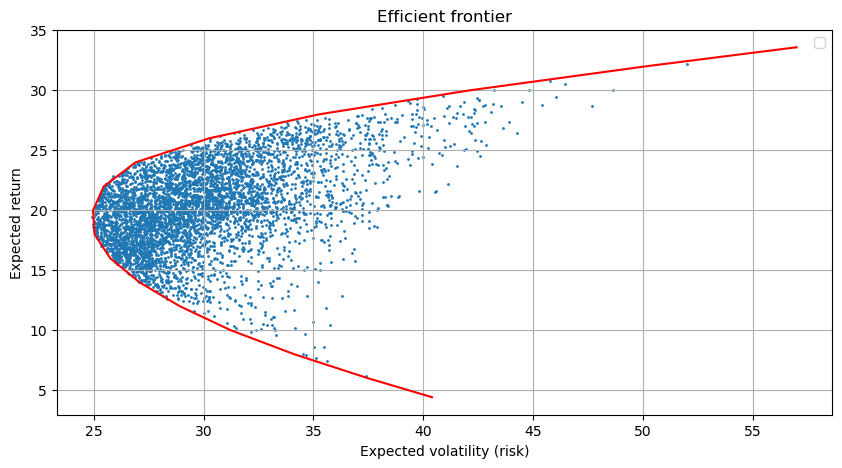

In [39]:
# plotting efficient frontier
returns_frontier = []
volatility_frontier = []

for r in range(1, 150):
    portfolio_target_return = r/50
    result = minimize(std_portfolio, initial_weights, args = args, method = 'SLSQP', bounds = bounds, constraints = constraints)
    optimal_weights = result.x
    ef_porfolio_return = yearly_mean_returns.dot(optimal_weights)   # efficient frontier portfolio return
    returns_frontier.append(ef_porfolio_return)
    #
    ef_porfolio_variance = np.dot(np.dot(optimal_weights.T, yearly_cov_matrix), optimal_weights)   # efficient frontier portfolio variance
    ef_porfolio_std = np.sqrt(ef_porfolio_variance)   # efficient frontier portfolio std
    volatility_frontier.append(ef_porfolio_std)

ef_portfolio = pd.DataFrame({'Return': returns_frontier, 'Volatility': volatility_frontier}) * 100

plt.figure(figsize = (10,5))
plt.plot(ef_portfolio['Volatility'], ef_portfolio['Return'], color = 'r')
plt.scatter(random_portfolios['Volatility'], random_portfolios['Return'], s = 1)

plt.title("Efficient frontier")
plt.xlabel("Expected volatility (risk)")
plt.ylabel("Expected return")
plt.legend()
plt.grid(True)
plt.show()

-------

In [41]:
# calculating value at risk (VaR) and expected shortfall (ES) using historical simulation (1-day at 95% confidence level) for the optimal portfolio
portfolio_hist_returns = returns.dot(optimal_weights)

VaR_95 = np.percentile(portfolio_hist_returns, 5)   # 5th percentile for 95% confidence level
ES_95 = portfolio_hist_returns[portfolio_hist_returns <= VaR_95].mean()

# printing the VaR and ES values
print(f"1-day VaR (95% confidence level) calculated using historical simulation is equal to {VaR_95*100:.3f}%.")
print(f"1-day ES (95% confidence level) calculated using historical simulation is equal to {ES_95*100:.3f}%.")

1-day VaR (95% confidence level) calculated using historical simulation is equal to -5.275%.
1-day ES (95% confidence level) calculated using historical simulation is equal to -8.312%.


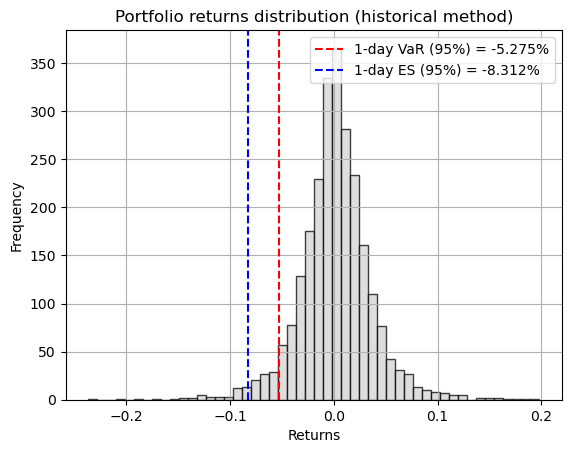

In [42]:
# plotting the portfolio historical returns along with VaR and ES
plt.hist(portfolio_hist_returns, bins = 50, alpha = 0.75, color = 'lightgray', edgecolor = 'black')
plt.axvline(VaR_95, color = 'red', linestyle = '--', label = f"1-day VaR (95%) = {VaR_95*100:.3f}%")
plt.axvline(ES_95, color = 'blue', linestyle = '--', label = f"1-day ES (95%) = {ES_95*100:.3f}%")
plt.title("Portfolio returns distribution (historical method)")
plt.xlabel("Returns")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Stress testing

Stress testing in portfolio optimization is a risk management technique used to evaluate how the portfolio would perform under extreme market conditions. The stress test would be performed via the Monte-Carlo simulations of the portfolio performance within the assumed time horizon.

In [45]:
# Monte-Carlo simulation parameters  #####################################
no_sim = 100000   # number of Monte-Carlo runs
time_horizon = 30   # number of days

# generating Monte-Carlo scenarios
simulated_returns = np.random.multivariate_normal(mean_returns, cov_matrix, size = (time_horizon, no_sim))

# calculating cumulative returns for each simulation
cumulative_returns = np.exp(simulated_returns.cumsum(axis = 0))

# performance of the optimal portfolio per each simulation
simulated_portfolio_values = np.dot(cumulative_returns, opt_weights)
simulated_portfolio_returns = simulated_portfolio_values - 1

In [46]:
# stress test: analyzing worst-case scenarios
VaR_95 = np.percentile(simulated_portfolio_returns[-1], 5)   # 5th percentile for 95% confidence level
VaR_99 = np.percentile(simulated_portfolio_returns[-1], 1)   # 1st percentile for 99% confidence level

# printing the VaR values
print(f"{time_horizon}-day VaR (95% confidence level) calculated using Monte-Carlo simulation is equal to {VaR_95*100:.3f}%.")
print(f"{time_horizon}-day VaR (99% confidence level) calculated using Monte-Carlo simulation is equal to {VaR_99*100:.3f}%.")

30-day VaR (95% confidence level) calculated using Monte-Carlo simulation is equal to -10.883%.
30-day VaR (99% confidence level) calculated using Monte-Carlo simulation is equal to -16.056%.


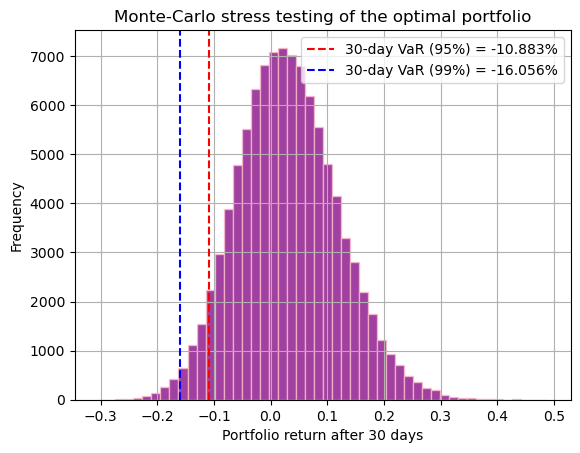

In [47]:
# plotting the simulated optimal portfolio returns with the values at risk
plt.hist(simulated_portfolio_returns[-1], bins = 50, alpha = 0.75, color = 'purple', edgecolor = 'pink')
plt.axvline(VaR_95, color = 'red', linestyle = 'dashed', label = f"{time_horizon}-day VaR (95%) = {VaR_95*100:.3f}%")
plt.axvline(VaR_99, color = 'blue', linestyle = 'dashed', label = f"{time_horizon}-day VaR (99%) = {VaR_99*100:.3f}%")
plt.title("Monte-Carlo stress testing of the optimal portfolio")
plt.xlabel(f"Portfolio return after {time_horizon} days")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Mean-variance portfolio optimization with a GARCH(1,1)-based 30-day volatility forecast

GARCH models are used to predict volatility of returns on financial assets. The models help to analyze time-series data where the variance error is believed to be serially autocorrelated. GARCH models assume that the variance of the error term follows an autoregressive moving average process.  
The proposed GARCH-based approach provides a realistic, forward-looking portfolio optimization based on volatility forecasting.

In [50]:
# fitting GARCH(1,1) model for each stock and getting the annualized volatility forecasts
garch_volatility_forecasts = {}
for t in tickers:
    model = arch_model(returns[t], vol = 'Garch', p = 1, q = 1)
    garch_fit = model.fit(disp = 'off')
    forecast = garch_fit.forecast(horizon = 30)   # 30-day forecast, uses the last appropriate data point as a start = returns.index[-2]
    garch_volatility_forecasts[t] = np.sqrt(forecast.variance.iloc[-1].mean()) * np.sqrt(trading_days)   # annualized volatility forecasts

In [51]:
# constructing GARCH(1,1)-forecasted covariance matrix
diag_garch_volatilities = np.diag(list(garch_volatility_forecasts.values()))
garch_cov_matrix = diag_garch_volatilities.dot(corr_matrix).dot(diag_garch_volatilities)

In [52]:
# mean-variance portfolio optimization using the GARCH(1,1) forecasts
args = yearly_mean_returns, garch_cov_matrix

# constraints for portfolio optimization: weights sum to 1  #####################################
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

opt_result = minimize(std_portfolio, initial_weights, args = args, method = 'SLSQP', bounds = bounds, constraints = constraints)
opt_weights = opt_result.x

# calculating optimal portfolio performance
opt_return = mean_portfolio(opt_weights, *args)
opt_volatility = std_portfolio(opt_weights, *args)

Optimal portfolio weights:
+--------+--------+-------+------+
| AAPL   | BA     | GOOG  | TSLA |
+--------+--------+-------+------+
| 0.6552 | 0.2358 | 0.109 | 0.0  |
+--------+--------+-------+------+
Optimal portfolio expected return: 18.58%
Optimal portfolio volatility (30-day forecast): 21.45%


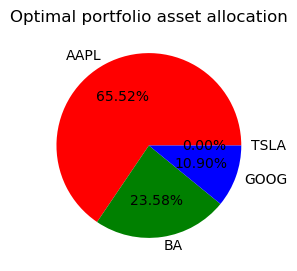

In [53]:
print(f"Optimal portfolio weights:")
d = [tickers, np.round(opt_weights, 4)]
print(tabulate(d, tablefmt = 'grid'))
#
print(f"Optimal portfolio expected return: {opt_return*100:.2f}%")
print(f"Optimal portfolio volatility (30-day forecast): {opt_volatility*100:.2f}%")
#
plt.figure(figsize = (5,3))
plt.pie(opt_weights, labels = tickers, autopct = '%1.2f%%', colors = asset_colors)
plt.title("Optimal portfolio asset allocation")
plt.show()

### Maximizing Sharpe ratio portfolio optimization with a GARCH(1,1)-based 30-day volatility forecast

The maximum Sharpe ratio refers to asset combination in which the return over the risk-free rate is high compared to volatility.

The Sharpe ratio is a measure of risk-adjusted portfolio returns and is calculated as $\textrm{Sharpe ratio} = \frac{\textrm{portfolio return} - \textrm{risk-free rate}}{\textrm{standard deviation of the portfolio excess return}}$.

Positive Sharpe ratio ranges are as follows. The range $[0.0, 0.99)$ is considered low risk/low reward, $[1.0, 1.99)$ - good, $[2.0, 2.99)$ - very good, above $3.0$ - outstanding. Negative Sharpe ratios indicate that the investment has very high risk and very low reward.

-------

#### Real risk-free rate calculation

In [58]:
%%skip
# fetching the nominal risk-free rate (using the current 3-month U.S. Treasury Bill (T-bill) yield)
def get_nominal_rfr():
    t_bill = yf.Ticker('^IRX')   # the ticker for the 13-week (3-month) U.S. T-bill rate
    t_bill_data = t_bill.history(period = '1d')
    
    nominal_rate = t_bill_data['Close'].iloc[-1] / 100   # percentage convertion to decimal
    
    return nominal_rate

# webscraping the annual inflation rate as the Personal Consumption Expenditures price index 
# (most recent value from the U.S. Bureau of Economic Analysis) | CPI U.S. BLS inaccessible for scraping
def get_inflation_rate():
    url = 'https://www.bea.gov/data/personal-consumption-expenditures-price-index'
    html_page = requests.get(url).text
    soup = BeautifulSoup(html_page, 'html.parser')
    
    tables = soup.find_all('tbody')
    rows = tables[0].find_all('tr')
    cols = rows[0].find_all('td')
    
    inflation_rate_text = cols[-1].get_text()
    inflation_rate = float(inflation_rate_text.strip().replace('%', '')) / 100   # percentage convertion to decimal
    
    return inflation_rate

# calculating the real annual risk-free rate
def calc_real_rfr(nominal_rate, inflation_rate):
    real_rfr = (1 + nominal_rate) / (1 + inflation_rate) - 1
    
    return real_rfr

In [59]:
%%skip
nominal_rate = get_nominal_rfr()
inflation_rate = get_inflation_rate()
real_rate = calc_real_rfr(nominal_rate, inflation_rate)
r = round(real_rate, 4)
r

In [60]:
# assuming the risk-free rate value from 28/02/2025 as pertaining to the forecast period
r = 0.0165

In [61]:
# calculating daily risk-free rate
risk_free_rate = r / trading_days
risk_free_rate

6.547619047619048e-05

-------

In [63]:
# defining the Sharpe ratio function
def negative_sharpe_ratio(weights, yearly_mean_returns, cov_matrix, risk_free_rate):
    
    portfolio_return = np.dot(weights, yearly_mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    
    return -sharpe_ratio   # negative for minimization in scipy.optimize (= maximization)

# optimizing portfolio weights to maximize the Sharpe ratio
args = yearly_mean_returns, garch_cov_matrix, risk_free_rate
opt_result = minimize(negative_sharpe_ratio, initial_weights, args = args, method = 'SLSQP', bounds = bounds, constraints = constraints)
opt_weights = opt_result.x

# computing optimized portfolio metrics
opt_return = np.dot(opt_weights, yearly_mean_returns)
opt_volatility = np.sqrt(np.dot(opt_weights.T, np.dot(garch_cov_matrix, opt_weights)))
opt_sharpe_ratio = (opt_return - risk_free_rate) / opt_volatility

Optimal portfolio weights:
+--------+-----+--------+-------+
| AAPL   | BA  | GOOG   | TSLA  |
+--------+-----+--------+-------+
| 0.9267 | 0.0 | 0.0373 | 0.036 |
+--------+-----+--------+-------+
Optimal portfolio expected return: 23.67%
Optimal portfolio volatility (30-day forecast): 23.08%
Optimal portfolio Sharpe ratio: 1.03


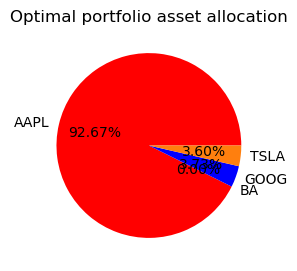

In [64]:
print(f"Optimal portfolio weights:")
d = [tickers, np.round(opt_weights, 4)]
print(tabulate(d, tablefmt = 'grid'))
#
print(f"Optimal portfolio expected return: {opt_return*100:.2f}%")
print(f"Optimal portfolio volatility (30-day forecast): {opt_volatility*100:.2f}%")
print(f"Optimal portfolio Sharpe ratio: {opt_sharpe_ratio:.2f}")
#
plt.figure(figsize = (5,3))
plt.pie(opt_weights, labels = tickers, autopct = '%1.2f%%', colors = asset_colors)
plt.title("Optimal portfolio asset allocation")
plt.show()

###### Anna Nakonieczna, Feb 2025